Loading and preprocessing training data...
Loading and preprocessing validation data...
Loading and preprocessing test data...

Class distribution before balancing:
high: 1219 samples (34.0%)
low: 1184 samples (33.0%)
medium: 1181 samples (33.0%)

Applying SMOTE to balance training data...

Class distribution after SMOTE balancing:
high: 1219 samples (33.3%)
low: 1219 samples (33.3%)
medium: 1219 samples (33.3%)

Class weights for weighted loss function:
high: 0.98
low: 1.01
medium: 1.01

Training data shape after resampling: (3657, 83), Labels shape: (3657,)
Validation data shape: (768, 83), Labels shape: (768,)
Test data shape: (768, 83), Labels shape: (768,)
Number of classes: 3
Class boundaries (quantiles): [1018.     3811.8526]
Class names: ['high' 'low' 'medium']

Training TabNet model...


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.74381 | val_0_accuracy: 0.34115 |  0:00:01s
epoch 1  | loss: 1.54874 | val_0_accuracy: 0.32812 |  0:00:02s
epoch 2  | loss: 1.33408 | val_0_accuracy: 0.36589 |  0:00:02s
epoch 3  | loss: 1.31815 | val_0_accuracy: 0.36719 |  0:00:03s
epoch 4  | loss: 1.23883 | val_0_accuracy: 0.36198 |  0:00:04s
epoch 5  | loss: 1.20635 | val_0_accuracy: 0.36979 |  0:00:05s
epoch 6  | loss: 1.17113 | val_0_accuracy: 0.42708 |  0:00:06s
epoch 7  | loss: 1.13321 | val_0_accuracy: 0.45964 |  0:00:07s
epoch 8  | loss: 1.07687 | val_0_accuracy: 0.51432 |  0:00:07s
epoch 9  | loss: 1.0543  | val_0_accuracy: 0.5013  |  0:00:08s
epoch 10 | loss: 1.11847 | val_0_accuracy: 0.50391 |  0:00:09s
epoch 11 | loss: 1.09963 | val_0_accuracy: 0.5026  |  0:00:10s
epoch 12 | loss: 1.06607 | val_0_accuracy: 0.4987  |  0:00:11s
epoch 13 | loss: 1.07988 | val_0_accuracy: 0.49609 |  0:00:12s
epoch 14 | loss: 1.02919 | val_0_accuracy: 0.48828 |  0:00:13s
epoch 15 | loss: 1.04865 | val_0_accuracy: 0.45443 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Best Validation Accuracy: 0.7227 (at epoch 65)
Test Accuracy: 0.7435

Classification Report (includes Recall and F1-score):
              precision    recall  f1-score   support

        high       0.82      0.79      0.80       256
         low       0.98      0.62      0.76       252
      medium       0.59      0.82      0.69       260

    accuracy                           0.74       768
   macro avg       0.80      0.74      0.75       768
weighted avg       0.79      0.74      0.75       768


Macro F1 Score (Test Set): 0.7489

Confusion Matrix:
[[202   1  53]
 [  0 155  97]
 [ 44   2 214]]


KeyError: 0

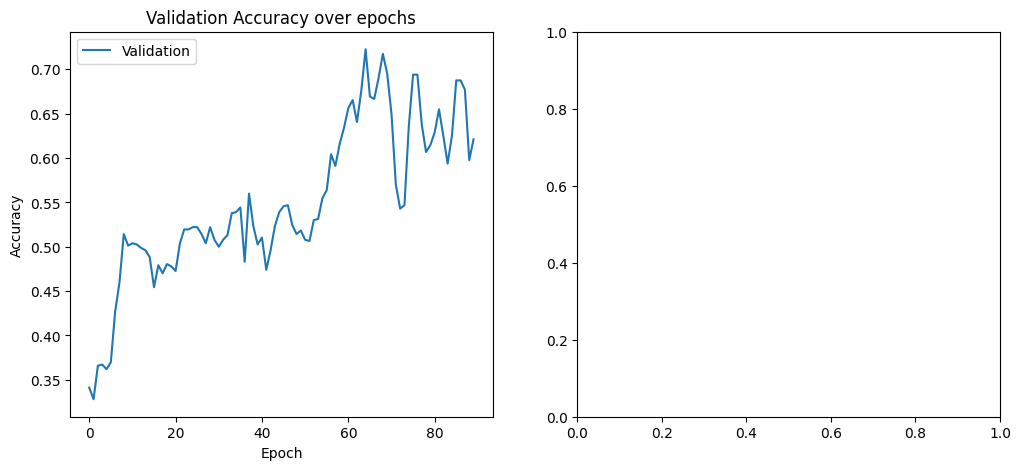

In [3]:
# -*- coding: utf-8 -*-
# TabNet for Crop Production Classification (3 Classes)

# This script implements TabNet for classifying crop production levels
# into 3 classes based on tabular data using PyTorch and pytorch_tabnet.

## 1. Setup and Imports

# Install required packages
# !pip install pytorch-tabnet scikit-learn pandas numpy matplotlib seaborn

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE

# Import TabNet
from pytorch_tabnet.tab_model import TabNetClassifier
import torch

# Define file paths for session upload
TRAIN_PATH = "train.csv"
VALID_PATH = "validation.csv"
TEST_PATH = "test.csv"

## 2. Load and Preprocess Data

def load_and_preprocess(file_path, scaler=None, fit_scaler=False, label_encoder=None, fit_encoder=False):
    """Loads data, preprocesses features, and converts target to 3 classes."""
    df = pd.read_csv(file_path)

    # Define class boundaries based on quantiles for 3 classes
    # Using 33rd and 66th percentiles for even distribution
    if fit_scaler:  # Only compute quantiles on training data
        quantiles = np.quantile(df["Production (M.Ton)"], [0.33, 0.66])
        feature_scaler = StandardScaler()
    else:
        # These will be provided from training data
        if scaler is None:
            raise ValueError("Scaler must be provided if fit_scaler is False")
        quantiles, feature_scaler = scaler  # Unpack the tuple of (quantiles, feature_scaler)

    # Create class labels based on quantiles
    bins = [-np.inf, quantiles[0], quantiles[1], np.inf]
    labels = ["low", "medium", "high"]

    # Convert target variable to classes
    df["Production_Category"] = pd.cut(df["Production (M.Ton)"], bins=bins, labels=labels, right=True)

    # Separate features and target
    X = df.drop(["Production (M.Ton)", "Production_Category"], axis=1)
    y = df["Production_Category"]

    # Identify numerical features (excluding one-hot encoded Crop and District)
    # Assuming columns starting with 'Crop_' or 'District_' are one-hot encoded
    numerical_cols = [col for col in X.columns if not col.startswith("Crop_") and not col.startswith("District_")]

    # Scale numerical features
    if fit_scaler:
        X[numerical_cols] = feature_scaler.fit_transform(X[numerical_cols])
    else:
        X[numerical_cols] = feature_scaler.transform(X[numerical_cols])

    # Encode labels
    if fit_encoder:
        le = LabelEncoder()
        y_encoded = le.fit_transform(y)
    else:
        if label_encoder is None:
            raise ValueError("LabelEncoder must be provided if fit_encoder is False")
        y_encoded = label_encoder.transform(y)

    # For TabNet, we don't need to reshape the data or convert to one-hot encoding
    # TabNet works directly with 2D tabular data

    if fit_scaler and fit_encoder:
        return X.values, y_encoded, (quantiles, feature_scaler), le
    elif fit_scaler:
         return X.values, y_encoded, (quantiles, feature_scaler)
    elif fit_encoder:
        return X.values, y_encoded, label_encoder
    else:
        return X.values, y_encoded

# Load and preprocess data
print("Loading and preprocessing training data...")
X_train, y_train, scalers, label_encoder = load_and_preprocess(TRAIN_PATH, fit_scaler=True, fit_encoder=True)

print("Loading and preprocessing validation data...")
X_val, y_val = load_and_preprocess(VALID_PATH, scaler=scalers, label_encoder=label_encoder)

print("Loading and preprocessing test data...")
X_test, y_test = load_and_preprocess(TEST_PATH, scaler=scalers, label_encoder=label_encoder)

quantiles, feature_scaler = scalers

# Print class distribution before balancing
print("\nClass distribution before balancing:")
for i, class_name in enumerate(label_encoder.classes_):
    count = np.sum(y_train == i)
    print(f"{class_name}: {count} samples ({count/len(y_train)*100:.1f}%)")

## 3. Address Class Imbalance

# Apply SMOTE to balance the training data
print("\nApplying SMOTE to balance training data...")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Print class distribution after balancing
print("\nClass distribution after SMOTE balancing:")
for i, class_name in enumerate(label_encoder.classes_):
    count = np.sum(y_train_resampled == i)
    print(f"{class_name}: {count} samples ({count/len(y_train_resampled)*100:.1f}%)")

# Calculate class weights for weighted loss function
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
print("\nClass weights for weighted loss function:")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"{class_name}: {class_weights[i]:.2f}")

# Convert class weights to sample weights (one weight per sample)
# This is needed because TabNet expects sample weights, not class weights
sample_weights = np.ones(len(y_train_resampled))
for i, weight in enumerate(class_weights):
    sample_weights[y_train_resampled == i] = weight

print(f"\nTraining data shape after resampling: {X_train_resampled.shape}, Labels shape: {y_train_resampled.shape}")
print(f"Validation data shape: {X_val.shape}, Labels shape: {y_val.shape}")
print(f"Test data shape: {X_test.shape}, Labels shape: {y_test.shape}")
print(f"Number of classes: {len(label_encoder.classes_)}")
print(f"Class boundaries (quantiles): {quantiles}")
print(f"Class names: {label_encoder.classes_}")

## 4. Build and Train the TabNet Model

# Define TabNet hyperparameters with explicit optimizer settings
tabnet_params = {
    'n_d': 64,               # Width of the decision prediction layer
    'n_a': 64,               # Width of the attention embedding for each mask
    'n_steps': 5,            # Number of steps in the architecture (usually 3-10)
    'gamma': 1.5,            # Coefficient for feature reusage in the masks
    'n_independent': 2,      # Number of independent GLU layers at each step
    'n_shared': 2,           # Number of shared GLU layers at each step
    'cat_idxs': [],          # List of categorical features indices
    'cat_dims': [],          # List of categorical features dimensions
    'cat_emb_dim': [],       # List of categorical features embedding dimensions
    'lambda_sparse': 1e-3,   # Sparsity regularization coefficient
    'optimizer_fn': torch.optim.Adam,  # Explicitly use Adam optimizer
    'optimizer_params': {'lr': 0.01},  # Explicit learning rate
    'mask_type': 'sparsemax', # Mask function to use - "sparsemax" or "entmax"
    'scheduler_params': {    # Scheduler parameters
        'step_size': 10,
        'gamma': 0.9
    },
    'scheduler_fn': torch.optim.lr_scheduler.StepLR,  # Explicit scheduler
    'seed': 42,              # Random seed for reproducibility
    'verbose': 1,            # Verbosity level
    'device_name': 'auto'    # Device to use ('auto', 'cpu', 'cuda')
}

# Initialize TabNet classifier
clf = TabNetClassifier(**tabnet_params)

# Train the model with sample weights (not class weights)
print("\nTraining TabNet model...")
clf.fit(
    X_train=X_train_resampled, y_train=y_train_resampled,
    eval_set=[(X_val, y_val)],
    eval_metric=['accuracy'],
    max_epochs=200,
    patience=25,
    batch_size=1024,
    virtual_batch_size=128,
    weights=sample_weights  # Using sample weights instead of class weights
)

## 5. Evaluate the Model

# Get best validation accuracy
best_val_metrics = clf.history["val_0_accuracy"]
best_val_accuracy = max(best_val_metrics)
best_epoch = np.argmax(best_val_metrics) + 1
print(f"\nBest Validation Accuracy: {best_val_accuracy:.4f} (at epoch {best_epoch})")

# Generate predictions on test set
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)

# Calculate test accuracy
test_accuracy = np.mean(y_pred == y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Print Classification Report with zero_division=0 to fix warnings
print("\nClassification Report (includes Recall and F1-score):")
print(classification_report(y_test, y_pred,
                           target_names=label_encoder.classes_,
                           zero_division=0))  # Fix for warnings

# Calculate and print Macro F1 Score separately
macro_f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
print(f"\nMacro F1 Score (Test Set): {macro_f1:.4f}")

# Print Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

## 6. Visualize Results

# Plot training history - FIXED to use correct keys in TabNet history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
# TabNet doesn't store train accuracy directly, only validation metrics
plt.plot(clf.history["val_0_accuracy"], label="Validation")
plt.title("Validation Accuracy over epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
# TabNet uses 'loss' for training loss
if 'loss' in clf.history:
    plt.plot(clf.history["loss"], label="Train Loss")
    plt.title("Loss over epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
plt.tight_layout()
plt.show()

# Plot Confusion Matrix Heatmap with percentages
plt.figure(figsize=(12, 10))
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Normalized Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# Plot raw counts confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix (Counts)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# Plot class distribution
plt.figure(figsize=(10, 6))
class_counts = [np.sum(y_train == i) for i in range(len(label_encoder.classes_))]
class_counts_resampled = [np.sum(y_train_resampled == i) for i in range(len(label_encoder.classes_))]

x = np.arange(len(label_encoder.classes_))
width = 0.35

plt.bar(x - width/2, class_counts, width, label='Original')
plt.bar(x + width/2, class_counts_resampled, width, label='After SMOTE')

plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Class Distribution Before and After SMOTE')
plt.xticks(x, label_encoder.classes_)
plt.legend()
plt.tight_layout()
plt.show()

## 7. Feature Importance Analysis (TabNet-specific)

# Get feature importance from the TabNet model
feature_importances = clf.feature_importances_

# Plot feature importance
plt.figure(figsize=(12, 8))
plt.barh(range(len(feature_importances)), feature_importances)
plt.yticks(range(len(feature_importances)), [f"Feature {i}" for i in range(len(feature_importances))])
plt.xlabel("Feature Importance")
plt.title("TabNet Feature Importance")
plt.tight_layout()
plt.show()

# Get the mask explanation for a specific sample (first test sample)
explain_matrix, masks = clf.explain(X_test[:1])

# Plot the explanation for the first sample
plt.figure(figsize=(20, 6))
plt.imshow(explain_matrix[0].T)
plt.title("TabNet Feature Selection for Sample 0")
plt.ylabel("Feature")
plt.xlabel("Decision Step")
plt.colorbar(label="Feature Importance")
plt.tight_layout()
plt.show()

print("\n--- End of Script ---")
